# Detect number from images

Train a model to detect the number in player shirts

## Load packages

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import numpy as np


In [11]:
import pandas as pd
import cv2
import os
import imutils
import pickle

## Load paths

In [12]:
from roboflow import Roboflow

rf = Roboflow(api_key="9D4i8D2WyWV3WFkjUuZ6")
project = rf.workspace("udla").project("shirt-number-recognition-rafes")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...


In [13]:
from pathlib import Path

# Set paths for local Windows environment
base_path = Path('./Shirt-number-Recognition-1')
output_path = Path('./models')  # Local path to save models
output_path.mkdir(exist_ok=True)

# Define paths for train, validation, and test sets
train_path = base_path / 'train'
valid_path = base_path / 'valid'
test_path = base_path / 'test'

def load_yolo_data(data_path, target_size=(224, 224)):
    """
    Load images and bounding boxes from YOLO format dataset.
    YOLO format: class_id x_center y_center width height (normalized)
    We convert to: startX, startY, endX, endY (normalized)
    """
    images = []
    targets = []
    filenames = []
    
    images_path = data_path / 'images'
    labels_path = data_path / 'labels'
    
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_files = []
    for ext in image_extensions:
        image_files.extend(list(images_path.glob(ext)))
    
    for img_file in image_files:
        # Find corresponding label file
        label_file = labels_path / (img_file.stem + '.txt')
        
        if not label_file.exists():
            continue
            
        # Load and preprocess image
        try:
            image = load_img(str(img_file), target_size=target_size)
            image = img_to_array(image) / 255.0
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            continue
        
        # Read label file and get first bounding box (if multiple exist)
        with open(label_file, 'r') as f:
            lines = f.readlines()
            if len(lines) == 0:
                continue
            
            # Take the first bounding box
            parts = lines[0].strip().split()
            if len(parts) >= 5:
                # YOLO format: class_id x_center y_center width height
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])
                
                # Convert to corner format: startX, startY, endX, endY
                startX = x_center - width / 2
                startY = y_center - height / 2
                endX = x_center + width / 2
                endY = y_center + height / 2
                
                # Clip values to [0, 1]
                startX = max(0, min(1, startX))
                startY = max(0, min(1, startY))
                endX = max(0, min(1, endX))
                endY = max(0, min(1, endY))
                
                images.append(image)
                targets.append([startX, startY, endX, endY])
                filenames.append(str(img_file))
    
    return np.array(images), np.array(targets), filenames

# Load training data
print("[INFO] Loading training data...")
trainImages, trainTargets, trainFilenames = load_yolo_data(train_path)
print(f"Loaded {len(trainImages)} training samples")

# Load validation data (use as test if test folder is empty)
print("[INFO] Loading validation data...")
validImages, validTargets, validFilenames = load_yolo_data(valid_path)
print(f"Loaded {len(validImages)} validation samples")

# Load test data
print("[INFO] Loading test data...")
testImages, testTargets, testFilenames = load_yolo_data(test_path)
print(f"Loaded {len(testImages)} test samples")

# If test set is empty, use validation set for testing
if len(testImages) == 0:
    print("[INFO] Test set is empty, using validation set for testing")
    testImages = validImages
    testTargets = validTargets
    testFilenames = validFilenames

print(f"\nData shapes:")
print(f"  trainImages: {trainImages.shape}")
print(f"  trainTargets: {trainTargets.shape}")
print(f"  testImages: {testImages.shape}")
print(f"  testTargets: {testTargets.shape}")

[INFO] Loading training data...
Loaded 81 training samples
[INFO] Loading validation data...
Loaded 2 validation samples
[INFO] Loading test data...
Loaded 16 test samples

Data shapes:
  trainImages: (81, 224, 224, 3)
  trainTargets: (81, 4)
  testImages: (16, 224, 224, 3)
  testTargets: (16, 4)
Loaded 81 training samples
[INFO] Loading validation data...
Loaded 2 validation samples
[INFO] Loading test data...
Loaded 16 test samples

Data shapes:
  trainImages: (81, 224, 224, 3)
  trainTargets: (81, 4)
  testImages: (16, 224, 224, 3)
  testTargets: (16, 4)


## Load data

images and respective number bounding boxes

### Example of a sample

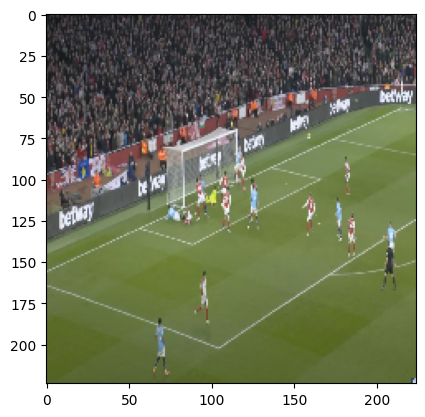

In [14]:
# image
plt.imshow(trainImages[0])

In [15]:
# number position
trainTargets[0]

array([    0.29933,     0.86365,     0.31269,     0.88897])

## Model Architecture

In [16]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = True

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [18]:
opt = Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=32,
    epochs=10,
    verbose=1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,936,548 (68.42 MB)

 Trainable params: 17,936,548 (68.42 MB)

 Non-trainable params: 0 (0.00 B)

None
[INFO] training bounding box regressor...
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0439 - val_loss: 0.0450
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0439 - val_loss: 0.0450
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0210 - val_loss: 0.0476
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0210 - val_loss: 0.0476
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0149 - val_loss: 0.0487
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0149 - val_loss: 0.0487
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0118 - val_loss: 0.0505
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0118 - val_loss: 0.0505
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0093 - val_loss: 0.0528
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0093 - val_loss: 0.0528
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.0072 - val_loss: 0.0561
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - l

In [19]:
# Save the model to local output path
model.save(output_path / 'number_detection.h5')
print(f"Model saved to {output_path / 'number_detection.h5'}")

Model saved to models\number_detection.h5


## Model performance

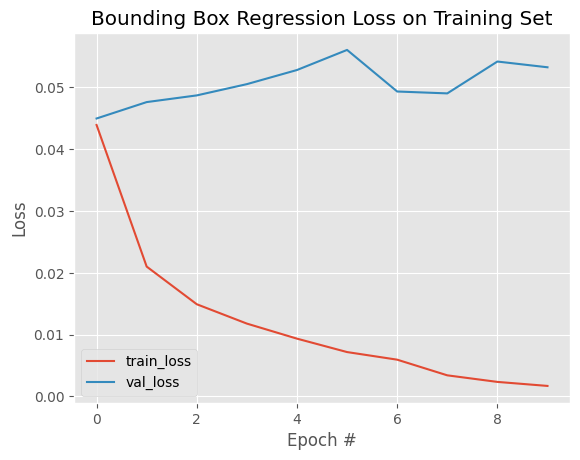

In [20]:
# plot the model training history
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## Example of predictions

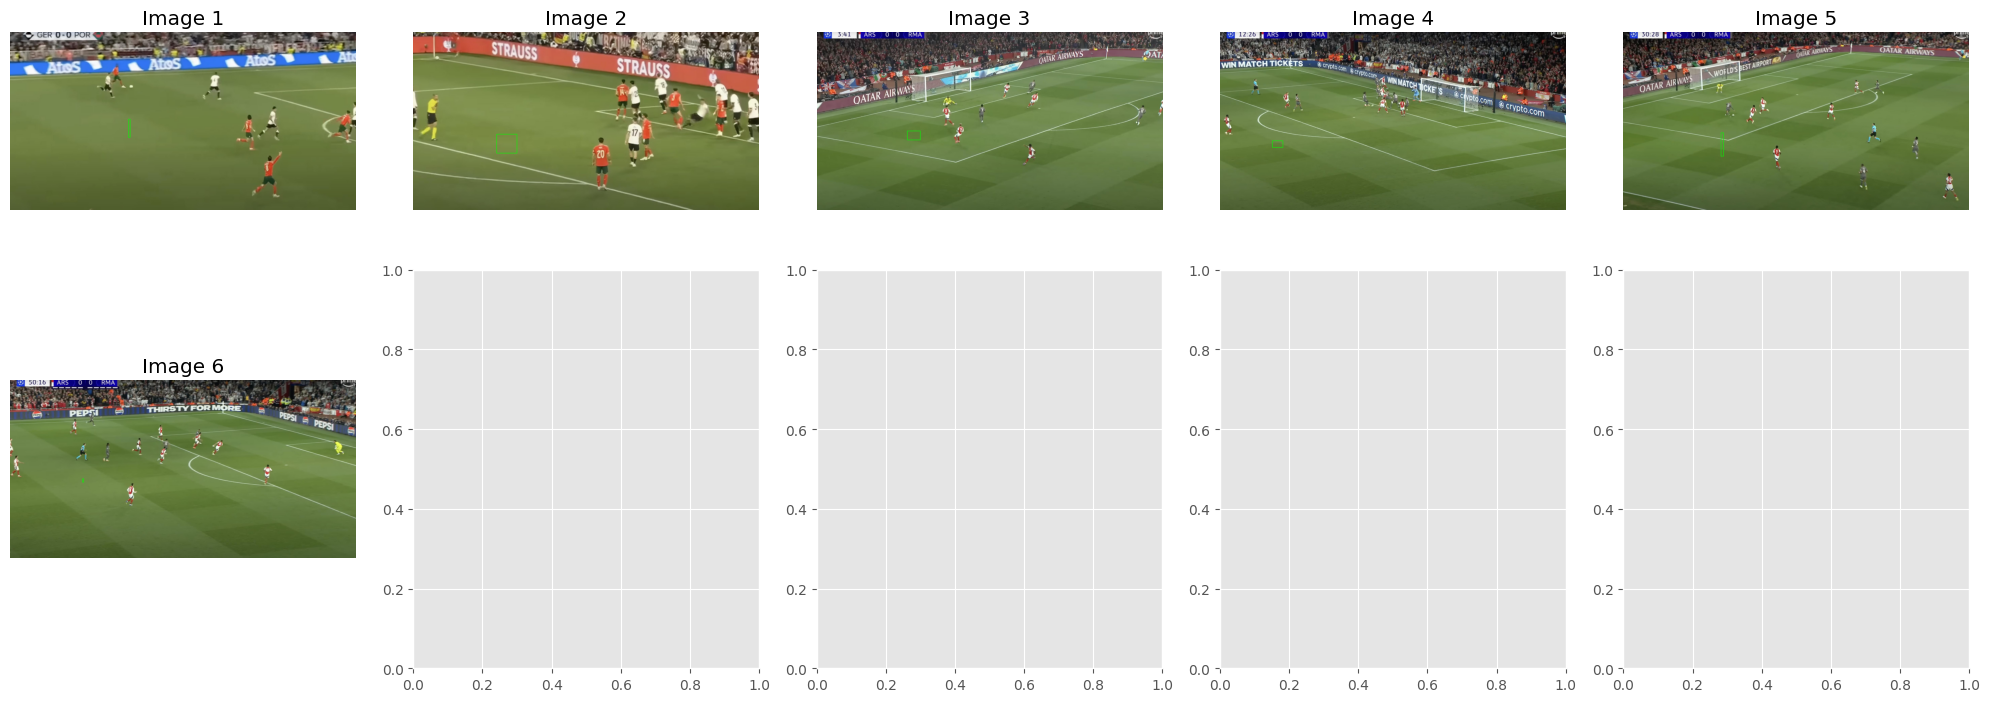

In [21]:
# Display predictions on test images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, imagePath in enumerate(testFilenames[10:20]):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image_expanded = np.expand_dims(image, axis=0)

    preds = model.predict(image_expanded, verbose=0)
    preds_bbox = preds[0]

    (startX, startY, endX, endY) = preds_bbox

    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image_cv = cv2.imread(imagePath)
    image_cv = imutils.resize(image_cv)
    (h, w) = image_cv.shape[:2]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX_scaled = int(startX * w)
    startY_scaled = int(startY * h)
    endX_scaled = int(endX * w)
    endY_scaled = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image_cv, (startX_scaled, startY_scaled), (endX_scaled, endY_scaled),
        (0, 255, 0), 2)

    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    
    # Display in subplot
    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f'Image {idx + 1}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()